 ## References 

 * Data source: https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/
 * Sample/starter code: https://github.com/Nir-J/ML-Projects/blob/master/UNSW-Network_Packet_Classification/unsw.py

In [1]:
%config IPCompleter.greedy=True
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib as matplot
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings("ignore")

from keras import Sequential
from keras.models import Model, load_model
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras import regularizers

from sklearn.metrics import * # f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,normalize


import xgboost, lightgbm
from mlxtend.classifier import EnsembleVoteClassifier

# Preprocessing (transformation/scaling) 

In [2]:
train = pd.read_csv('https://raw.githubusercontent.com/Nir-J/ML-Projects/master/UNSW-Network_Packet_Classification/UNSW_NB15_training-set.csv')
test = pd.read_csv('https://raw.githubusercontent.com/Nir-J/ML-Projects/master/UNSW-Network_Packet_Classification/UNSW_NB15_testing-set.csv')
combined_data = pd.concat([train, test]).drop(['id'],axis=1)

In [3]:
# Contaminsation mean pollution (outliers) in data
tmp = train.where(train['attack_cat'] == "Normal").dropna()
contamination = round(1 - len(tmp)/len(train), 2)
print("train contamination ", contamination)

tmp = test.where(test['attack_cat'] == "Normal").dropna()
print("test  contamination ", round(1 - len(tmp)/len(test),2),'\n')

if contamination > 0.5:
    print(f'contamination is {contamination}, which is greater than 0.5. Fixing...')
    contamination = round(1-contamination,2)
    print(f'contamination is now {contamination}')

train contamination  0.68
test  contamination  0.55 

contamination is 0.68, which is greater than 0.5. Fixing...
contamination is now 0.32


In [4]:
le1 = LabelEncoder()
le = LabelEncoder()

vector = combined_data['attack_cat']

print("attack cat:", set(list(vector))) # use print to make it print on single line 

combined_data['attack_cat'] = le1.fit_transform(vector)
combined_data['proto'] = le.fit_transform(combined_data['proto'])
combined_data['service'] = le.fit_transform(combined_data['service'])
combined_data['state'] = le.fit_transform(combined_data['state'])

vector = combined_data['attack_cat']
print('\nDescribing attack_type: ')
print("min", vector.min())
print("max", vector.max())
print("mode",vector.mode(), "Which is,", le1.inverse_transform(vector.mode()))
print("mode", len(np.where(vector.values==6)[0])/len(vector),"%")

attack cat: {'Fuzzers', 'Normal', 'Shellcode', 'Backdoor', 'Reconnaissance', 'Generic', 'Exploits', 'Worms', 'DoS', 'Analysis'}

Describing attack_type: 
min 0
max 9
mode 0    6
dtype: int32 Which is, ['Normal']
mode 0.3609225646458884 %


In [5]:
le1.inverse_transform([0,1,2,3,4,5,6,7,8,9])
combined_data.head(3)

array(['Analysis', 'Backdoor', 'DoS', 'Exploits', 'Fuzzers', 'Generic',
       'Normal', 'Reconnaissance', 'Shellcode', 'Worms'], dtype=object)

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,0.121478,113,0,4,6,4,258,172,74.087490,252,...,1,1,0,0,0,1,1,0,6,0
1,0.649902,113,0,4,14,38,734,42014,78.473372,62,...,1,2,0,0,0,1,6,0,6,0
2,1.623129,113,0,4,8,16,364,13186,14.170161,62,...,1,3,0,0,0,2,6,0,6,0


In [6]:
data_x = combined_data.drop(['attack_cat','label'], axis=1) # droped label
data_y = combined_data.loc[:,['label']]
# del combined_data # free mem
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=.20, random_state=42) # TODO

In [7]:
X_train.shape
y_train.shape
X_test.shape # test is larger... good 
y_test.shape

(206138, 42)

(206138, 1)

(51535, 42)

(51535, 1)

# Benchmark

In [10]:
# DTC = DecisionTreeClassifier()
RFC = RandomForestClassifier(n_estimators=150, random_state=42, n_jobs=-1)
ETC = ExtraTreesClassifier(n_estimators=200, random_state=42, n_jobs=-1)
XGB = xgboost.XGBClassifier(n_estimators=150, n_jobs=-1)
GBM = lightgbm.LGBMClassifier(objective='binary', n_estimators= 500) # multiclass

list_of_CLFs_names = []
list_of_CLFs = [ RFC, ETC, XGB, GBM]
ranking = []

for clf in list_of_CLFs:
    _ = clf.fit(X_train,y_train)
    pred = clf.score(X_test, y_test)
    pred = f1_score(y_test, clf.predict(X_test), average='weighted')
    name = str(type(clf)).split(".")[-1][:-2]
    print("F1_weighted: %0.5f for the %s" % (pred, name))

    ranking.append(pred)
    list_of_CLFs_names.append(name)

F1_weighted: 0.95242 for the RandomForestClassifier
F1_weighted: 0.95135 for the ExtraTreesClassifier
F1_weighted: 0.93660 for the XGBClassifier
F1_weighted: 0.95207 for the LGBMClassifier


In [15]:
# http://rasbt.github.io/mlxtend/user_guide/classifier/EnsembleVoteClassifier/#majority-voting-hard-voting
eclf = EnsembleVoteClassifier(clfs=list_of_CLFs, fit_base_estimators=False, voting='soft')
_ = eclf.fit(X_train, y_train)
pred = f1_score(y_test, eclf.predict(X_test), average='weighted')
name = str(type(clf)).split(".")[-1][:-2]
print("F1_weighted: %0.5f for the %s" % (pred, name))

# pred = eclf.predict(X_test)
# probas = eclf.predict_proba(X_test)

F1_weighted: 0.95305 for the LGBMClassifier


In [16]:
eclf = EnsembleVoteClassifier(clfs=list_of_CLFs, fit_base_estimators=False, voting='hard')
_ = eclf.fit(X_train, y_train)
pred = f1_score(y_test, eclf.predict(X_test), average='weighted')
name = str(type(clf)).split(".")[-1][:-2]
print("F1_weighted: %0.5f for the %s" % (pred, name))

F1_weighted: 0.95212 for the LGBMClassifier


## Unsupervied ML

In [30]:
# %%capture 
# !pip install pyod
# !pip install hdbscan
# !pip install combo
# !pip install SOM # https://github.com/AICoE/log-anomaly-detector/blob/master/Notebooks/SOM_retrain_notebook/SOM_UserFeedbackPOC.ipynb

In [31]:
import gc, os, pickle
from datetime import datetime

import numpy as np
import pandas as pd
from collections import Counter

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pyod
# from hdbscan import HDBSCAN

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.decomposition import * 
from sklearn.preprocessing import *
from sklearn.svm import *

In [32]:
from pyod.models import lof, cblof, cof, pca, iforest, knn, mcd, ocsvm, sod, abod, hbos #, auto_encoder, vae
contamination = 0.4
threshold = 0.75

## Uses PYOD

In [50]:
lof_clf = lof.LOF(contamination=contamination, n_jobs=-1)
_ = lof_clf.fit(X_train[:50000])

predictions = lof_clf.predict(X_train)
print(f'Acc of train: {accuracy_score(y_train, predictions):.5f}') 
print(f"F1_weighted of train: {f1_score(y_train, predictions, average='weighted'):.5f}")


predictions = lof_clf.predict(X_test)
print(f'Acc of test: {accuracy_score(y_test, predictions):.5f}')
print(f"F1_weighted of train: {f1_score(y_test, predictions, average='weighted'):.5f}")


Acc of train: 0.53236
F1_weighted of train: 0.53833
Acc of test: 0.53271
F1_weighted of train: 0.53961


In [40]:
cblof_clf = cblof.CBLOF(contamination=contamination, n_jobs=-1, n_clusters=45)
_ = cblof_clf.fit(X_train)

predictions = cblof_clf.predict(X_train)
print(f'Acc of train: {accuracy_score(y_train, predictions):.5f}') 
print(f"F1_weighted of train: {f1_score(y_train, predictions, average='weighted'):.5f}")

predictions = cblof_clf.predict(X_test)
print(f'Acc of test: {accuracy_score(y_test, predictions):.5f}')
print(f"F1_weighted of train: {f1_score(y_test, predictions, average='weighted'):.5f}")

Acc of train: 0.38804
F1_weighted of train: 0.39378
Acc of test: 0.39061
F1_weighted of train: 0.39650


In [43]:
cof_clf = cof.COF(contamination=contamination) # slow and mem intensive 10,000 soft limit 
_ = cof_clf.fit(X_train[:5000])

predictions = cof_clf.predict(X_train[:5000])
print(f'Acc of train: {accuracy_score(y_train[:5000], predictions):.5f}') 
print(f"F1_weighted of train: {f1_score(y_train[:5000], predictions, average='weighted'):.5f}")

predictions = cof_clf.predict(X_test[:10000])
print(f'Acc of test: {accuracy_score(y_test[:10000], predictions):.5f}')
print(f"F1_weighted of train: {f1_score(y_test[:10000], predictions, average='weighted'):.5f}")

Acc of train: 0.54560
F1_weighted of train: 0.54977
Acc of test: 0.53080
F1_weighted of train: 0.53259


In [44]:
# https://pyod.readthedocs.io/en/latest/_modules/pyod/models/pca.html
pca_clf = pca.PCA(contamination=contamination)
_ = pca_clf.fit(X_train)

predictions = pca_clf.predict(X_train)
print(f'Acc of train: {accuracy_score(y_train, predictions):.5f}') 
print(f"F1_weighted of train: {f1_score(y_train, predictions, average='weighted'):.5f}")

predictions = pca_clf.predict(X_test)
print(f'Acc of test: {accuracy_score(y_test, predictions):.5f}')
print(f"F1_weighted of train: {f1_score(y_test, predictions, average='weighted'):.5f}")

Acc of train: 0.45766
F1_weighted of train: 0.46274
Acc of test: 0.45546
F1_weighted of train: 0.46038


In [45]:
pca_clf = pca.PCA(2, contamination=contamination)
_ = pca_clf.fit(X_train)

predictions = pca_clf.predict(X_train)
print(f'Acc of train: {accuracy_score(y_train, predictions):.5f}') 
print(f"F1_weighted of train: {f1_score(y_train, predictions, average='weighted'):.5f}")

predictions = pca_clf.predict(X_test)
print(f'Acc of test: {accuracy_score(y_test, predictions):.5f}')
print(f"F1_weighted of train: {f1_score(y_test, predictions, average='weighted'):.5f}")

Acc of train: 0.48213
F1_weighted of train: 0.48699
Acc of test: 0.47977
F1_weighted of train: 0.48461


In [46]:
iforest_clf = iforest.IForest(contamination=contamination, n_estimators=300, max_samples= 1028, n_jobs=-1)
_ = iforest_clf.fit(X_train)

predictions = iforest_clf.predict(X_train)
print(f'Acc of train: {accuracy_score(y_train, predictions):.5f}') 
print(f"F1_weighted of train: {f1_score(y_train, predictions, average='weighted'):.5f}")

predictions = iforest_clf.predict(X_test)
print(f'Acc of test: {accuracy_score(y_test, predictions):.5f}')
print(f"F1_weighted of train: {f1_score(y_test, predictions, average='weighted'):.5f}")

Acc of train: 0.36601
F1_weighted of train: 0.37195
Acc of test: 0.36364
F1_weighted of train: 0.36922


In [47]:
# takes 30 mins.... 
knn_clf = knn.KNN(contamination=contamination, radius=1.5, n_neighbors=20, n_jobs=-1) #TODO radius
_ = knn_clf.fit(X_train)

predictions = knn_clf.predict(X_train)
print(f'Acc of train: {accuracy_score(y_train, predictions):.5f}') 
print(f"F1_weighted of train: {f1_score(y_train, predictions, average='weighted'):.5f}")

predictions = knn_clf.predict(X_test)
print(f'Acc of test: {accuracy_score(y_test, predictions):.5f}')
print(f"F1_weighted of train: {f1_score(y_test, predictions, average='weighted'):.5f}")

Acc of train: 0.40222
F1_weighted of train: 0.40721
Acc of test: 0.40167
F1_weighted of train: 0.40749


In [48]:
ocsvm_clf = ocsvm.OCSVM(contamination=contamination) # expensive? 
_ = ocsvm_clf.fit(X_train[:2000])

predictions = ocsvm_clf.predict(X_train)
print(f'Acc of train: {accuracy_score(y_train, predictions):.5f}') 
print(f"F1_weighted of train: {f1_score(y_train, predictions, average='weighted'):.5f}")

predictions = ocsvm_clf.predict(X_test)
print(f'Acc of test: {accuracy_score(y_test, predictions):.5f}')
print(f"F1_weighted of train: {f1_score(y_test, predictions, average='weighted'):.5f}")

Acc of train: 0.58778
F1_weighted of train: 0.48495
Acc of test: 0.58768
F1_weighted of train: 0.48301


In [49]:
X_temp = X_train.astype(np.float) 
abod_clf = abod.ABOD(contamination=contamination, n_neighbors=10, )
_ = abod_clf.fit(X_temp)


predictions = abod_clf.predict(X_train)
print(f'Acc of train: {accuracy_score(y_train, predictions)}')

predictions = abod_clf.predict(X_test)
print(f'Acc of test: {accuracy_score(y_test, predictions)}')

Acc of train: 0.3608602004482434
Acc of test: 0.3611720190162026


In [ ]:
hdbScan_clf = HDBSCAN(10, leaf_size=80)
_ = hdbScan_clf.fit(X_train)

hdbScan_clf_outliers = hdbScan_clf.outlier_scores_ > 0.15 # akin to clf.pred_proba 
print(round(100*sum(hdbScan_clf_outliers == True)/X_train.shape[0], 5),"% outliers")
print(accuracy_score(y_train, hdbScan_clf_outliers))

print('')

hdbScan_clf_outliers = hdbScan_clf.outlier_scores_ > 0.45 # akin to clf.pred_proba 
print(round(100*sum(hdbScan_clf_outliers == True)/X_train.shape[0], 5),"% outliers")
print(accuracy_score(y_train, hdbScan_clf_outliers))

13.31681 % outliers
0.32942009721642784

3.17845 % outliers
0.3606564534438095


In [56]:
# pip install suod

In [57]:
from suod.models.base import SUOD

# initialize a set of base outlier detectors to train and predict on
base_estimators = [
    knn.KNN(n_neighbors=5,  contamination=contamination, radius=1.5),
    knn.KNN(n_neighbors=15, contamination=contamination, radius=1.5),
    knn.KNN(n_neighbors=25, contamination=contamination, radius=1.5),
    lof.LOF(n_neighbors=5,  contamination=contamination),
    lof.LOF(n_neighbors=15, contamination=contamination),
    lof.LOF(n_neighbors=25, contamination=contamination),
    cblof.CBLOF(contamination=contamination, n_clusters=45),
    # cblof.CBLOF(contamination=contamination, n_clusters=25),
    hbos.HBOS(contamination=contamination, n_bins=10, tol=0.1),
    pca.PCA(contamination=contamination),
    pca.PCA(15, contamination=contamination),
    pca.PCA(3, contamination=contamination),
    pca.PCA(1, contamination=contamination),

    ocsvm.OCSVM(contamination=contamination),
    ocsvm.OCSVM(contamination=contamination),
    
    # iforest.IForest(contamination=contamination, n_estimators=50, max_samples=1028),
    # abod.ABOD(contamination=contamination, n_neighbors=10)
]

# initialize a SUOD model with all features turned on
model = SUOD(base_estimators=base_estimators, n_jobs=-1,  # number of workers
             rp_flag_global=True,  # global flag for random projection
             bps_flag=False,  # global flag for balanced parallel scheduling
             approx_flag_global=False,  # global flag for model approximation
             contamination=contamination)

_ = model.fit(X_train)  # fit all models with X
model.approximate(X_train)  # conduct model approximation if it is enabled
predicted_labels = model.predict(X_train)  # predict labels
# predicted_probs = model.predict_proba(X_train)  # predict outlying probability
# predicted_scores = model.decision_function(X_train)  # predict scores

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:   15.8s remaining:   47.6s


In [ ]:
# # // Not sure if I was drunk when I wrote this pile of shit.... pretty sure I wasn't... crap I have no excuse. 

# sum_by_row = np.sum(predicted_labels, axis=1) # predicted_labels is a tabel, cols are a ML model (CLF), rows are a sample (data point)
# votes_per_sample = np.sort(sum_by_row)
# votes_per_sample_idx = np.argsort(sum_by_row)

# tuples = zip(votes_per_sample, votes_per_sample_idx) ## doesn't copy the elements of these two sequences, but generates a new set of references to these
# sorted_tuples = sorted(tuples, key = lambda tup: tup[0], reverse=True)
# sorted_tuples = [tup for tup in sorted_tuples if tup[0] != 0]

# print('Average Votes as "Anomalous", from the set of "Anomalous" points', np.mean(sum_by_row[sum_by_row != 0]))

# for VOTES in range(10):
#     idx = [sorted_tuples[i][1] for i in range(len(sorted_tuples)) if sorted_tuples[i][0] >= VOTES]
#     print(f'% of Trues to Falses: {100*np.sum(y_train.iloc[idx]).values[0]/y_train.iloc[idx].shape[0]:.4f} with votes: {VOTES}')

In [ ]:
for i in range(11):
  y_hat = np.sum(predicted_labels, 1) > i
  print(f'accuracy_score: {accuracy_score(y_train, y_hat):.4f} for Number of votes: {i}')

In [ ]:
for i in range(11):
  y_hat = np.sum(predicted_labels, 1) > i
  print(f'accuracy_score: {accuracy_score(y_train, y_hat):.4f} for Number of votes: {i}')

accuracy_score: 0.5674 for Number of votes: 0
accuracy_score: 0.4923 for Number of votes: 1
accuracy_score: 0.4428 for Number of votes: 2
accuracy_score: 0.4071 for Number of votes: 3
accuracy_score: 0.3953 for Number of votes: 4
accuracy_score: 0.3769 for Number of votes: 5
accuracy_score: 0.3611 for Number of votes: 6
accuracy_score: 0.3490 for Number of votes: 7
accuracy_score: 0.3420 for Number of votes: 8
accuracy_score: 0.3503 for Number of votes: 9
accuracy_score: 0.3584 for Number of votes: 10


In [ ]:
from pyod.models import so_gaal, auto_encoder, vae

In [ ]:
data = X_train
dim = X_train.shape[1]

model = vae.VAE(contamination=contamination, encoder_neurons=[dim, dim-1],decoder_neurons=[dim-1,dim], epochs=15) 
_ = model.fit(data)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 43)           0                                            
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 43)           1892        input_3[0][0]                    
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 43)           1892        dense_10[0][0]                   
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 43)           0           dense_11[0][0]                   
____________________________________________________________________________________________

In [ ]:
y_train = model.predict(X_train)
# new_array = [tuple(row) for row in X_train[y_train]]
# EVIL = pd.DataFrame(set(new_array), columns = columns)
# EVIL

if isinstance(X_train, (np.ndarray)):
    rows = np.unique(X_train[y_train], axis =0) # need axis=0; "If None, array will be flattened.", Thats stupid -_- 
    pd.DataFrame(data=rows, columns=columns, dtype = np.int) 
else:
    df = X_train.iloc[y_train].drop_duplicates()
    df
    
y_train[df.index]

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,idx
124113,0.000006,119,2,5,2,0,114,0,166666.6608,254,...,14,14,19,0,0,0,14,19,0,0
112948,0.000005,119,0,5,2,0,524,0,200000.0051,254,...,1,1,1,0,0,0,1,1,0,1


array([0, 0])

In [ ]:
%%capture
gan = so_gaal.SO_GAAL(contamination=0.3, stop_epochs=10)
_ = gan.fit(X_train)

In [ ]:
y_train = gan.predict(X_train)

if isinstance(X_train, (np.ndarray)):
    rows = np.unique(X_train[y_train], axis =0) # need axis=0; "If None, array will be flattened.", Thats stupid -_- 
    pd.DataFrame(data=rows, columns=columns, dtype = np.int)  
else:
    df = X_train.iloc[y_train].drop_duplicates()

In [ ]:
y_train[df.index]

array([0])

In [ ]:
wanted_explained_variance_ratio = 0.99
steps_down = 5
wanted_n_components = X_train.shape[1]
first_time = True

for i in range(X_train.shape[1], 0, -steps_down):
  total_var_ratio = round(np.sum(PCA(n_components=i).fit(X_train).explained_variance_ratio_),5)
  print('i =', i, 'with a variance ratio of', total_var_ratio)
  if total_var_ratio < wanted_explained_variance_ratio and first_time:
    wanted_n_components = i + steps_down
    first_time = False
print("We should set n_components to: ", wanted_n_components)

# X_train = PCA(n_components=wanted_n_components).fit_transform(X_train)

print("-----------------------------------\nTruncatedSVD")

wanted_explained_variance_ratio = 0.99
steps_down = 1
wanted_n_components = X_train.shape[1]
first_time = True

for i in range(X_train.shape[1]-1, 0, -steps_down):
  total_var_ratio = round(np.sum(TruncatedSVD(n_components=i).fit(X_train).explained_variance_ratio_),5)
  print('i =', i, 'with a variance ratio of', total_var_ratio)
  if total_var_ratio < wanted_explained_variance_ratio and first_time:
    wanted_n_components = i + steps_down
    first_time = False
print("We should set n_components to: ", wanted_n_components)

# X_train = PCA(n_components=wanted_n_components).fit_transform(X_train)

NameError: name 'PCA' is not defined

In [ ]:
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import *

from matplotlib import pyplot as plt
import pylab
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


<Figure size 648x432 with 0 Axes>

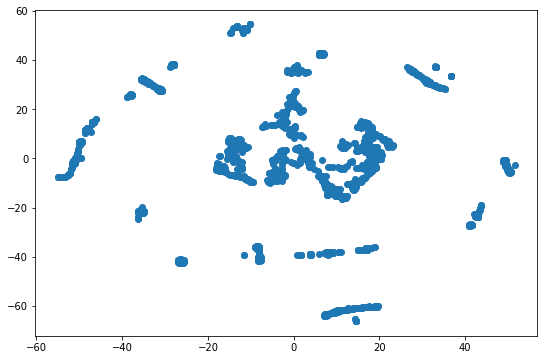

In [ ]:
#TSNE(2) == StandardScaler( TSNE(2) )
x, y = list(zip(*(TSNE(n_components=2, random_state=0).fit_transform(X_train[:1500]))))

plt.figure(figsize=(9, 6))
plt.scatter(x, y)
plt.show()

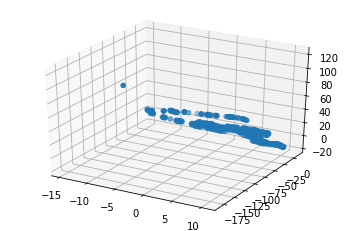

In [ ]:
#TSNE(3)
data = TSNE(n_components=3, random_state=12).fit_transform(X_train[:900])
x, y, z = list(zip(*data))

fig = pylab.figure()
ax = fig.add_subplot(111, projection = '3d')
sc = ax.scatter(x,y,z)

<Figure size 648x432 with 0 Axes>

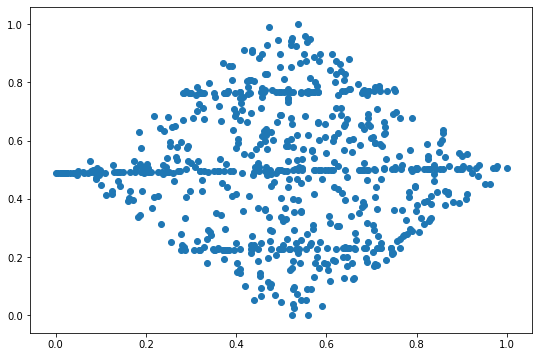

In [ ]:
# PCA(2) # little difference from StandardScaler vs MinMaxScaler
x, y = list(zip(*MinMaxScaler().fit_transform(PCA(2).fit_transform(X_train[:1500]))))

plt.figure(figsize=(9, 6))
plt.scatter(x, y)
plt.show()

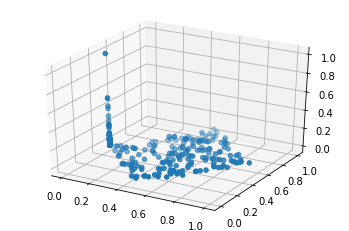

In [ ]:
# PCA(3)
x, y, z = list(zip(*MinMaxScaler().fit_transform(PCA(3).fit_transform(X_train[:400]))))

fig = pylab.figure()
ax = fig.add_subplot(111, projection = '3d')
sc = ax.scatter(x,y,z)